In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import VGG16
import os
import pandas as pd
from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

2024-04-09 20:37:48.804843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 20:37:48.804980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 20:37:48.974799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
dataset = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


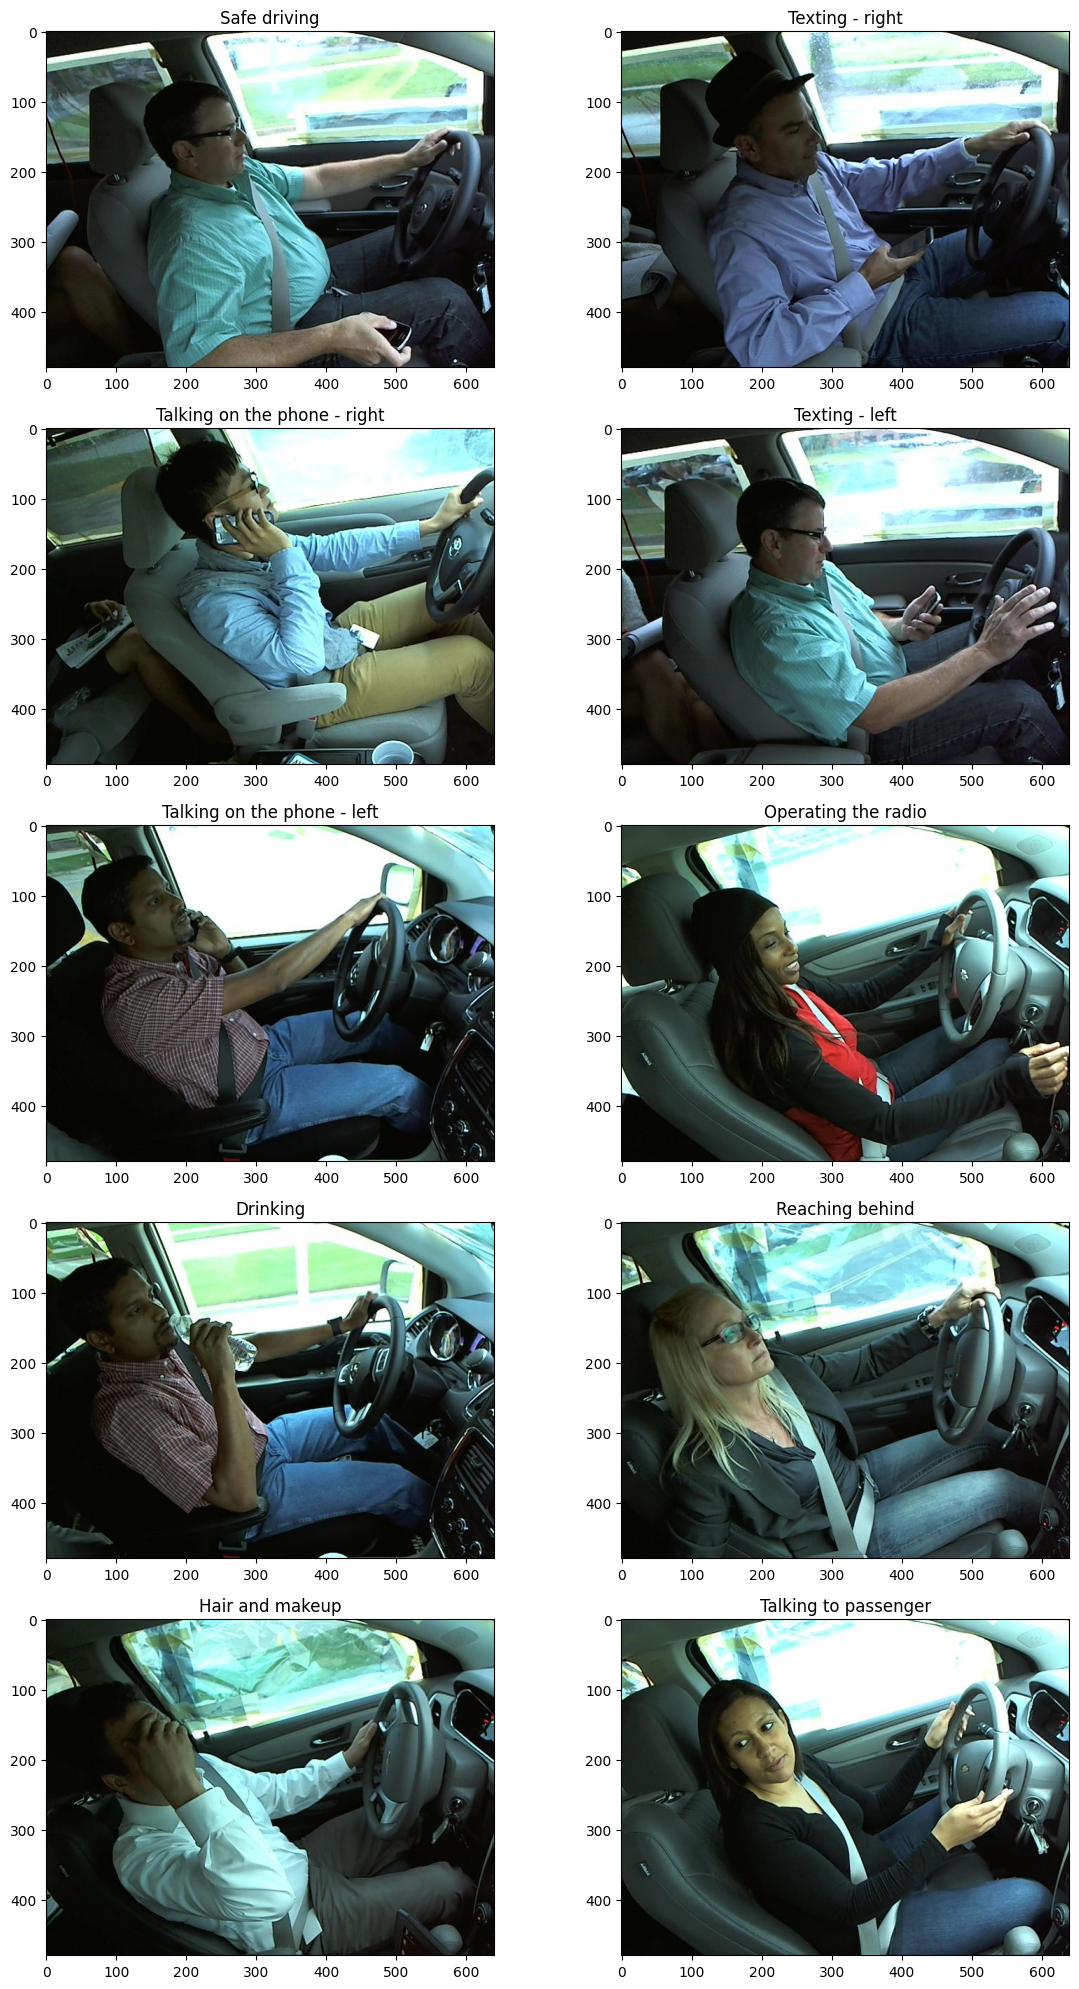

In [11]:
safe_activities = ['c0']
not_safe_activities = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

plt.figure(figsize=(12, 20))
image_count = 1
BASE_URL = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/'

for directory in safe_activities:
    for i, file in enumerate(os.listdir(BASE_URL + directory)):
        if i == 1: 
            break
        else:
            fig = plt.subplot(5, 2, image_count)
            image_count += 1
            image = mpimg.imread(BASE_URL + directory + '/' + file)
            plt.imshow(image)
            plt.title(activity_map[directory])

for directory in not_safe_activities:
    for i, file in enumerate(os.listdir(BASE_URL + directory)):
        if i == 1:
            break
        else:
            fig = plt.subplot(5, 2, image_count)
            image_count += 1
            image = mpimg.imread(BASE_URL + directory + '/' + file)
            plt.imshow(image)
            plt.title(activity_map[directory])

plt.tight_layout()
plt.show()


In [12]:
train = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
test = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'

In [13]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

training_set = train_datagen.flow_from_directory(train, 
                                                 target_size = (240, 240), 
                                                 batch_size = 32,
                                                 class_mode='categorical',
                                                 subset = 'training')

validation_set = train_datagen.flow_from_directory(train, 
                                                   target_size = (240, 240), 
                                                   batch_size = 32,
                                                   class_mode='categorical',
                                                   subset = 'validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [14]:
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title + ' - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ' - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

In [29]:

network = models.Sequential()
network.add(layers.Flatten(input_shape=(240, 240, 3)))  # Flatten the input image
network.add(layers.Dense(512, activation='relu', name='layer1'))  
network.add(layers.Dense(265, activation='relu', name='layer2'))
network.add(layers.Dense(128, activation='relu', name='layer3'))
network.add(layers.Dense(10, activation='softmax')) 

# Compile the model
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
network.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 172800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 512)            │    88,474,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 265)            │       135,945 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 128)            │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,645,395 (338.16 MB)

 Trainable params: 88,645,395 (338.16 MB)

 Non-trainable params: 0 (0.00 B)

**#BaslineDense**

In [31]:
dense_bmodel = network.fit(training_set,
                      validation_data=validation_set,
                      steps_per_epoch=len(training_set)//32,
                      epochs=30)


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.1012 - loss: 11.9599 - val_accuracy: 0.1114 - val_loss: 4.5974
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step - accuracy: 0.0885 - loss: 5.6056 - val_accuracy: 0.1573 - val_loss: 4.3492
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.1292 - loss: 4.7141 - val_accuracy: 0.1326 - val_loss: 3.5330
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.1331 - loss: 3.7903 - val_accuracy: 0.1872 - val_loss: 3.0550
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.1620 - loss: 3.2730 - val_accuracy: 0.2457 - val_loss: 2.5174
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.2261 - loss: 2.5472 - val_accuracy: 0.2107 - val_loss: 3.1159
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.1939 - loss: 2.7034 - val_accuracy: 0.2406 - val_loss: 2.1812
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.2217 - loss: 2.4313 - val_accuracy: 0.2848 - val_loss

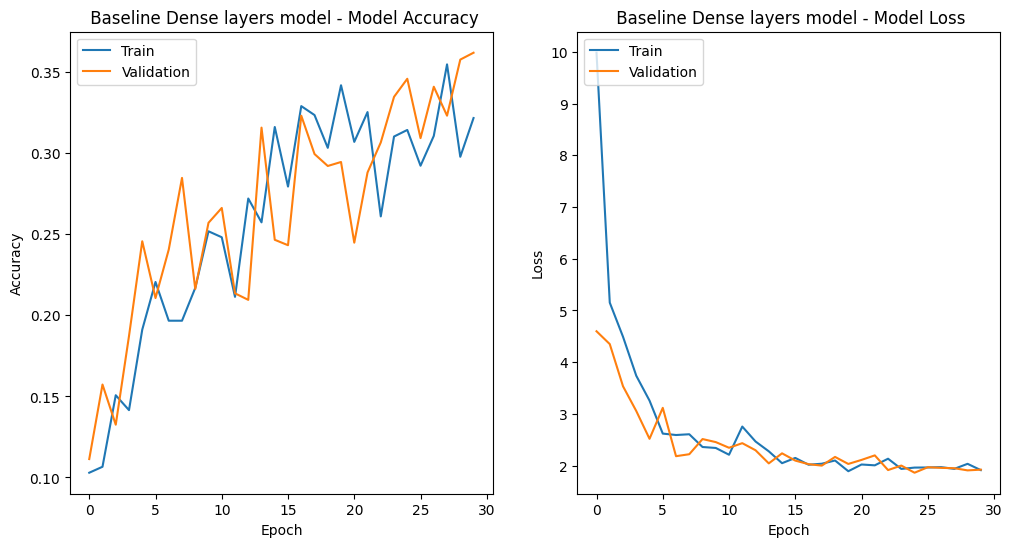

In [32]:
plot_history(dense_bmodel, " Baseline Dense layers model")

In [8]:
classifier = Sequential()
classifier.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (240, 240, 3), data_format = 'channels_last'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 1024, activation = 'relu'))
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 238, 238, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 119, 119, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 117, 117, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,051,946 (99.38 MB)

 Trainable params: 26,051,946 (99.38 MB)

 Non-trainable params: 0 (0.00 B)

**#BaselineCNN**

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [15]:
cnnm = classifier.fit(training_set,
                      validation_data=validation_set,
                      steps_per_epoch=len(training_set)//32,
                      epochs=50,
                     validation_steps = len(validation_set)//32, callbacks=[early_stopping,mc])


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1343 - loss: 2.6236
Epoch 1: val_accuracy improved from -inf to 0.04688, saving model to best_model.h5.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.1335 - loss: 2.6137 - val_accuracy: 0.0469 - val_loss: 2.3034
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1169 - loss: 2.3011
Epoch 2: val_accuracy improved from 0.04688 to 0.08594, saving model to best_model.h5.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - accuracy: 0.1175 - loss: 2.3009 - val_accuracy: 0.0859 - val_loss: 2.2984
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1309 - loss: 2.2841
Epoch 3: val_accuracy improved from 0.08594 to 0.20312, saving model to best_model.h5.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 110s 7s/step - accuracy: 0.1309 - loss: 2.2838 - val_accuracy: 0.2031 - val_loss: 2.2711
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1639 - loss: 2.2717
Epoch 4: val_accuracy did not improve from 0.20312
17/17 ━

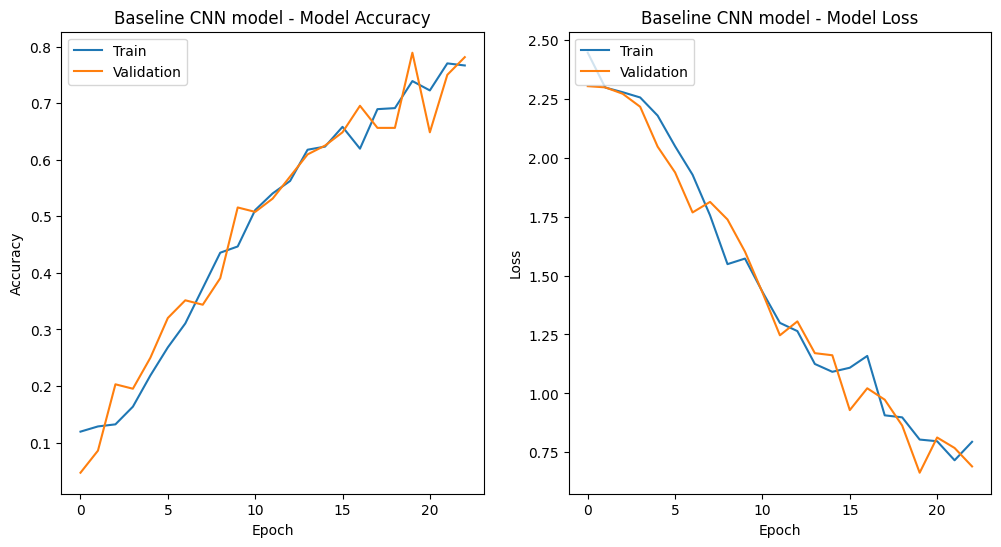

In [16]:
plot_history(cnnm, "Baseline CNN model")

In [19]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 238, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 119, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,722 (49.36 MB)

 Trainable params: 12,939,722 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
cnn = cnn_model.fit(training_set,
                      validation_data=validation_set,
                      steps_per_epoch=len(training_set)//32,
                      epochs=50,callbacks=[early_stopping,mc])


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0812 - loss: 2.7068
Epoch 1: val_accuracy did not improve from 0.78906
17/17 ━━━━━━━━━━━━━━━━━━━━ 204s 12s/step - accuracy: 0.0823 - loss: 2.6950 - val_accuracy: 0.0948 - val_loss: 2.3031
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1043 - loss: 2.3059
Epoch 2: val_accuracy did not improve from 0.78906
17/17 ━━━━━━━━━━━━━━━━━━━━ 184s 11s/step - accuracy: 0.1043 - loss: 2.3058 - val_accuracy: 0.1056 - val_loss: 2.2986
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1284 - loss: 2.2968
Epoch 3: val_accuracy did not improve from 0.78906
17/17 ━━━━━━━━━━━━━━━━━━━━ 184s 11s/step - accuracy: 0.1286 - loss: 2.2967 - val_accuracy: 0.1984 - val_loss: 2.2773
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


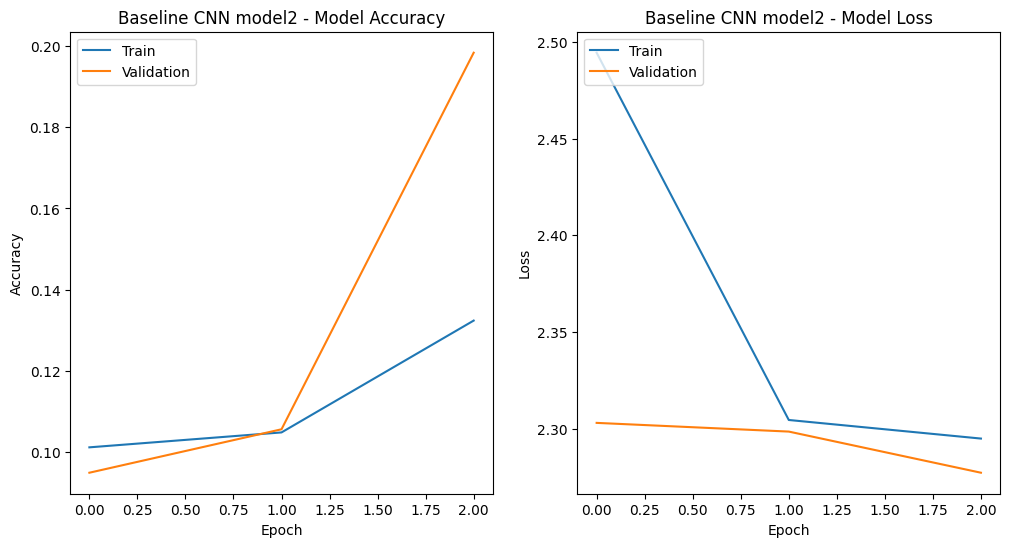

In [21]:
plot_history(cnn, "Baseline CNN model2")

applying transform learning (VGG16) with another preprocessing and augmentation(90%)

In [ ]:
gen_per_image = 1
gen_per_class = 200
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

def pad_img(img):
    h, w = img.shape[:2]
    new_h = int((5 + secrets.randbelow(16)) * h / 100) + h
    new_w = int((5 + secrets.randbelow(16)) * w / 100) + w

    full_sheet = np.ones((new_h, new_w, 3)) * 255

    p_X = secrets.randbelow(new_h - img.shape[0])
    p_Y = secrets.randbelow(new_w - img.shape[1])

    full_sheet[p_X : p_X + img.shape[0], p_Y : p_Y + img.shape[1]] = img

    full_sheet = cv2.resize(full_sheet, (w, h), interpolation = cv2.INTER_AREA)

    return full_sheet.astype(np.uint8)

def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img
BATCH_SIZE = 128
IMAGE_SIZE = 224
NUM_EPOCH = 400
#Initialise the parameters for Augmentation.
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_img)


train_data = datagen.flow_from_directory(train,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='training',shuffle=False)

valid_data = datagen.flow_from_directory(train,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                         subset='validation',shuffle=False)

In [45]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:

train_vgg16 = model.predict(train_data,verbose=1)
valid_vgg16 = model.predict(valid_data,verbose=1)

141/141 ━━━━━━━━━━━━━━━━━━━━ 5201s 37s/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1286s 36s/step


In [47]:
train_data.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [48]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (17943, 7, 7, 512)
Validation shape (4481, 7, 7, 512)


In [49]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)


Train features shape (7, 7, 512)
Validation features shape (7, 7, 512)


In [50]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,130 (20.04 KB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
VGG16_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_history = VGG16_model.fit(train_vgg16,train_data.classes,validation_data = (valid_vgg16,valid_data.classes),epochs=100,shuffle=True,callbacks=[early_stopping,mc])

Epoch 1/100
547/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 0.1016
Epoch 1: val_accuracy improved from 0.71094 to 0.89734, saving model to best_model.h5.keras
561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9713 - loss: 0.1014 - val_accuracy: 0.8973 - val_loss: 0.6587
Epoch 2/100
554/561 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9728 - loss: 0.0886
Epoch 2: val_accuracy improved from 0.89734 to 0.90716, saving model to best_model.h5.keras
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9728 - loss: 0.0886 - val_accuracy: 0.9072 - val_loss: 0.5779
Epoch 3/100
550/561 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9720 - loss: 0.0901
Epoch 3: val_accuracy did not improve from 0.90716
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9720 - loss: 0.0902 - val_accuracy: 0.9016 - val_loss: 0.6193
Epoch 4/100
542/561 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.0947
Epoch 4: val_accuracy did not improve from 0.90716
561/561 ━━━━━━━

In [23]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
from keras.models import load_model

# Load the trained model
model = load_model('best_model.h5.keras') 

<Sequential name=sequential_5, built=True>


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_path = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test/'

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

# Flow from directory for test data
test_dataset = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode=None,  # Since this is a test set, we don't have class labels
    shuffle=False  # Keep the order of predictions consistent with file names
)

# Generate predictions on the test data
predictions = VGG16_model.predict(test_dataset, verbose=1)

# Get the file names from the test dataset
file_names = test_dataset.filenames

# Vectorized concatenation of file names with predictions
arr = np.column_stack([file_names, predictions])

# Create a DataFrame with the desired columns and save to CSV
submission_df = pd.DataFrame(arr, columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
submission_df.to_csv('./submission.csv', index=False)
